In [9]:
import mne
import numpy as np
import os
import fnmatch
import pandas as pd
import sklearn
import sigproc
import decoding
import openpyxl
from matplotlib import pyplot as plt
import utils
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import settings
from joblib import Memory, Parallel, delayed
import mne.stats as stats 
import pickle
import scipy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random 
import itertools

In [3]:
# analysis settings
data_filepath = r"c:\\sync_folder\\TSRlearn\\Data\\"
os.chdir(data_filepath)
subject_name = "pilot_sianna"
subject_list = [subject_name]

data_path = os.path.join(data_filepath + subject_name)

ex_per_fold = 2

clf_params = {
    "C": 1 / 0.006,
    "max_iter": 1000,
    "penalty": "l1",
    "solver": "liblinear",
}

clf = LogisticRegression(**clf_params)

# concepts
concepts = [
    "beetle","berry","bicycle","bird","box","car","chair","coffee","dog","face","fish",
    "guitar","hammer","hand","house","jacket","pencil","phone","pizza","plane","tree"
]
colors_list = ["#54478c","#2c699a","#048ba8","#0db39e","#16db93","#83e377","#b9e769","#efea5a","#f1c453","#f29e4c",
               "#264653","#287271","#2a9d8f","#8ab17d","#babb74","#e9c46a","#efb366","#f4a261","#ee8959","#e76f51",
               "#d23f0f"]


load the pre-processed and segmented data

Procedure
1. Train and test on all possible timepoint combinations (with get_best_timepoint, leave one out)
2. find the best timepoint for localiser training
3. plot timecourse of decoding accuracy (averaged across concept-decoders)

In [4]:
all_files = os.listdir(data_path)

preprocessed_files = fnmatch.filter(all_files, '*epoched*.fif')
data_preprocessed = mne.read_epochs((data_path + '//' + preprocessed_files[0]), verbose=False)
data_preprocessed


C:\Users\sianna.groesser\AppData\Local\Temp\ipykernel_21152\230916490.py:4: RuntimeWarning: This filename (c:\\sync_folder\\TSRlearn\\Data\\pilot_sianna//pilot1_Sianna_epoched_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  data_preprocessed = mne.read_epochs((data_path + '//' + preprocessed_files[0]), verbose=False)


<EpochsFIF | 840 events (all good), -0.1 – 0.5 s (baseline off), ~125.2 MiB, data loaded,
 '1': 40
 '2': 40
 '3': 40
 '4': 40
 '5': 40
 '6': 40
 '7': 40
 '8': 40
 '9': 40
 '10': 40
 and 11 more events ...>

Prepare the MEG Data for classification

In [5]:
data_meg = data_preprocessed.get_data()
data_y = data_preprocessed.events[:,2]

# split by sensors 
picks_grad = mne.pick_types(data_preprocessed.info, meg='grad')
picks_mag  = mne.pick_types(data_preprocessed.info, meg='mag')

# slice the data
data_grad = data_meg[:, picks_grad, :]   
data_mag  = data_meg[:, picks_mag, :] 

# rescale MEG data
grad_rescaled = settings.rescale_meg(data_grad)

mag_rescaled  = settings.rescale_meg(data_mag)

# 
data_x = np.hstack((grad_rescaled, mag_rescaled))

Compute Decoding Accuracy for all classifiers and plot

In [6]:
## Calculation of best timepoint and leave-one-out cross-validation
res = utils.get_best_timepoint(
       data_x, data_y, clf=clf, 
       subj=subject_name, ex_per_fold=ex_per_fold,
       return_preds=True
   )

df_out=res[0]
preds = res[1]

# save
# with open("res_pilot1.pkl", "wb") as f:
#    pickle.dump(res, f)

CV Fold pilot_sianna: 100%|██████████| 20/20 [23:54<00:00, 71.74s/it]


In [ ]:
# # load pickle 
# file = open("res_pilot1.pkl",'rb')
# res = pickle.load(file)
# file.close()

#df_out=res[0]
#preds = res[1]

Peak (averaged) accuracy: 0.08452380952380953
Peak time (ms): 140


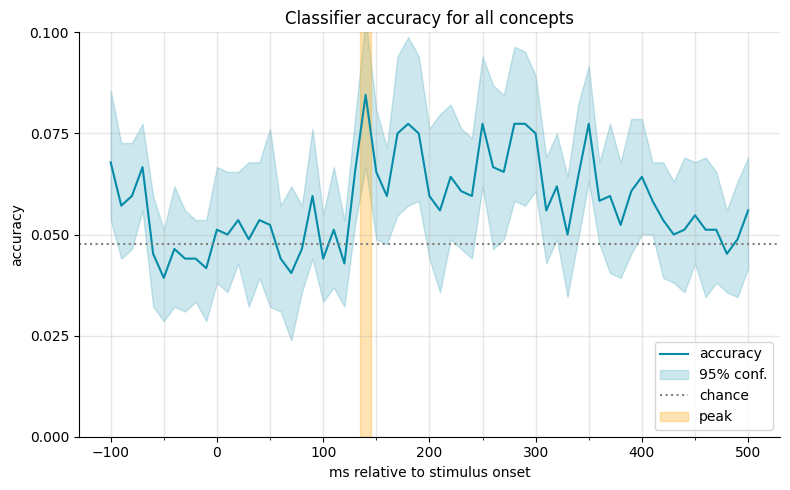

In [6]:

# mean across folds at each timepoint
g = df_out.groupby("timepoint", sort=True)["mean_accuracy"]
curve_mean = g.mean()
# curve_ci   = 1.96 * g.std(ddof=1) / np.sqrt(g.count())  

peak_time = curve_mean.idxmax()
peak_acc  = curve_mean.max()

print("Peak (averaged) accuracy:", peak_acc)
print("Peak time (ms):", peak_time)


# plot predictions over time: one subplot per classifier 
fig = plt.figure(figsize=(8,5))
ax = fig.subplots()
sns.despine()


utils.plot_decoding_accuracy(
    df_out, x="timepoint", y="mean_accuracy", ax=ax, color=colors_list[2],
    chance=(1/len(concepts))
)
ax.set(
    xlabel="ms relative to stimulus onset",
    ylabel="accuracy",
    title="Classifier accuracy for all concepts",
)
ax.set_ylim(0, 0.1)
ax.set_yticks([0, 0.025, 0.05, 0.075,0.1])

# highlight peak decoding time
ax.axvspan(peak_time - 5, peak_time + 5, alpha=0.3, color="orange")

ax.legend(["accuracy", "95% conf.", "chance", "peak"], loc="lower right")

plt.tight_layout()
plt.pause(0.1)
#fig.savefig(f"decoding_accuracy_pilot1.png", bbox_inches="tight")

Repeat same analysis but exclude faces

In [12]:
face_idx = concepts.index("face")  
face_number = face_idx+1
facetrials_idx = data_y==face_number

data_x_noface = data_x[~facetrials_idx]
data_y_noface = data_y[~facetrials_idx]

# run classifcation on subset with no faces 
res = utils.get_best_timepoint(
    data_x_noface,
    data_y_noface,
    clf=clf,
    subj=subject_name,
    ex_per_fold=ex_per_fold,
    return_preds=True
)

df_out, preds = res


CV Fold pilot_sianna: 100%|██████████| 20/20 [21:21<00:00, 64.05s/it]


Peak (averaged) accuracy: 0.0775
Peak time (ms): 350


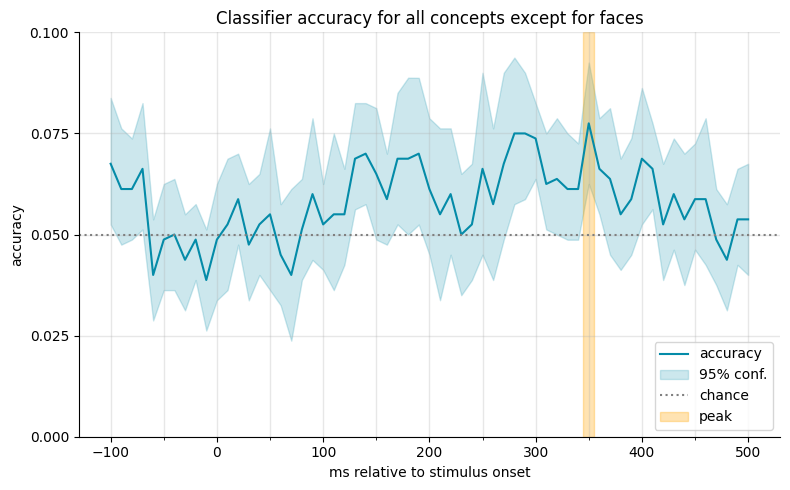

In [15]:
g = df_out.groupby("timepoint", sort=True)["mean_accuracy"]
curve_mean = g.mean()
# curve_ci   = 1.96 * g.std(ddof=1) / np.sqrt(g.count())  

peak_time = curve_mean.idxmax()
peak_acc  = curve_mean.max()

print("Peak (averaged) accuracy:", peak_acc)
print("Peak time (ms):", peak_time)


# plot predictions over time: one subplot per classifier 
fig = plt.figure(figsize=(8,5))
ax = fig.subplots()
sns.despine()


utils.plot_decoding_accuracy(
    df_out, x="timepoint", y="mean_accuracy", ax=ax, color=colors_list[2],
    chance=(1/(len(concepts)-1))
)
ax.set(
    xlabel="ms relative to stimulus onset",
    ylabel="accuracy",
    title="Classifier accuracy for all concepts except for faces",
)
ax.set_ylim(0, 0.1)
ax.set_yticks([0, 0.025, 0.05, 0.075,0.1])

# highlight peak decoding time
ax.axvspan(peak_time - 5, peak_time + 5, alpha=0.3, color="orange")

ax.legend(["accuracy", "95% conf.", "chance", "peak"], loc="lower right")

plt.tight_layout()
plt.pause(0.1)
fig.savefig(f"decoding_accuracy_nofaces_pilot1.png", bbox_inches="tight")

Iteratively select more concepts and see how decoding probability changes 

In [ ]:

repetitions = 5
accuracies_sets = np.zeros((20))
setsizes = range(2,22)
labels = np.unique(data_y)  

for setidx, setsize in enumerate(setsizes):

    max_acc_list =  []

    # all possible concept subsets of this size
    all_combos = list(itertools.combinations(labels, setsize))

    # pick random combos without replacement
    chosen_combos = random.sample(all_combos, k=repetitions)

    for Subset in chosen_combos:  
              
        label_mask = np.isin(data_y, Subset)
        # shape (840,), boolean
 
        train_x = data_x[label_mask]
        train_y = data_y[label_mask]
        res = utils.get_best_timepoint(
            train_x, train_y, clf=clf, subj=subject_name, ex_per_fold=ex_per_fold,
            return_preds=False, proba=False)
        
        g = res.groupby("timepoint", sort=True)["mean_accuracy"]
        curve_mean = g.mean()
        # average over folds first 

        max_acc = curve_mean.max()
        max_acc_list.append(max_acc)

    accuracies_sets[setidx] = np.mean(max_acc_list)
    print(f"max accuracy for subset {Subset}: {accuracies_sets[setidx]}")


CV Fold pilot_sianna: 100%|██████████| 20/20 [00:02<00:00,  7.65it/s]


max accuracy for subset (np.int32(2), np.int32(3)): 0.7225


CV Fold pilot_sianna: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


max accuracy for subset (np.int32(4), np.int32(15), np.int32(16)): 0.5016666666666667


CV Fold pilot_sianna: 100%|██████████| 20/20 [01:17<00:00,  3.87s/it]


max accuracy for subset (np.int32(1), np.int32(2), np.int32(8), np.int32(9)): 0.36000000000000004


CV Fold pilot_sianna: 100%|██████████| 20/20 [02:18<00:00,  6.93s/it]


max accuracy for subset (np.int32(4), np.int32(5), np.int32(6), np.int32(13), np.int32(14)): 0.306


CV Fold pilot_sianna: 100%|██████████| 20/20 [02:33<00:00,  7.66s/it]


max accuracy for subset (np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(19), np.int32(20)): 0.2575


CV Fold pilot_sianna: 100%|██████████| 20/20 [02:50<00:00,  8.54s/it]


max accuracy for subset (np.int32(1), np.int32(9), np.int32(10), np.int32(11), np.int32(16), np.int32(18), np.int32(20)): 0.22928571428571426


CV Fold pilot_sianna: 100%|██████████| 20/20 [03:36<00:00, 10.81s/it]


max accuracy for subset (np.int32(1), np.int32(3), np.int32(7), np.int32(13), np.int32(17), np.int32(18), np.int32(20), np.int32(21)): 0.19625


CV Fold pilot_sianna: 100%|██████████| 20/20 [04:49<00:00, 14.46s/it]


max accuracy for subset (np.int32(1), np.int32(3), np.int32(4), np.int32(7), np.int32(10), np.int32(13), np.int32(17), np.int32(18), np.int32(20)): 0.18722222222222223


CV Fold pilot_sianna: 100%|██████████| 20/20 [05:46<00:00, 17.32s/it]


max accuracy for subset (np.int32(1), np.int32(2), np.int32(7), np.int32(9), np.int32(11), np.int32(15), np.int32(17), np.int32(19), np.int32(20), np.int32(21)): 0.15950000000000003


CV Fold pilot_sianna: 100%|██████████| 20/20 [06:56<00:00, 20.85s/it]


max accuracy for subset (np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(8), np.int32(10), np.int32(12), np.int32(15), np.int32(17), np.int32(19)): 0.1590909090909091


CV Fold pilot_sianna: 100%|██████████| 20/20 [08:09<00:00, 24.45s/it]


max accuracy for subset (np.int32(2), np.int32(3), np.int32(4), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(12), np.int32(17), np.int32(18), np.int32(19), np.int32(20)): 0.14166666666666666


CV Fold pilot_sianna: 100%|██████████| 20/20 [09:06<00:00, 27.34s/it]


max accuracy for subset (np.int32(1), np.int32(2), np.int32(5), np.int32(7), np.int32(8), np.int32(9), np.int32(11), np.int32(12), np.int32(13), np.int32(15), np.int32(17), np.int32(18), np.int32(19)): 0.1280769230769231


CV Fold pilot_sianna: 100%|██████████| 20/20 [10:49<00:00, 32.46s/it]


max accuracy for subset (np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(7), np.int32(8), np.int32(10), np.int32(12), np.int32(13), np.int32(16), np.int32(17), np.int32(18), np.int32(20)): 0.11892857142857143


CV Fold pilot_sianna: 100%|██████████| 20/20 [11:44<00:00, 35.20s/it]


max accuracy for subset (np.int32(1), np.int32(2), np.int32(4), np.int32(6), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(21)): 0.11366666666666667


CV Fold pilot_sianna: 100%|██████████| 20/20 [13:00<00:00, 39.03s/it]


max accuracy for subset (np.int32(1), np.int32(2), np.int32(4), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(17), np.int32(18), np.int32(19), np.int32(21)): 0.10406249999999999


CV Fold pilot_sianna: 100%|██████████| 20/20 [14:59<00:00, 44.98s/it]


max accuracy for subset (np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(14), np.int32(15), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21)): 0.10029411764705883


CV Fold pilot_sianna: 100%|██████████| 20/20 [16:35<00:00, 49.78s/it]


max accuracy for subset (np.int32(2), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21)): 0.09833333333333334


CV Fold pilot_sianna: 100%|██████████| 20/20 [18:34<00:00, 55.72s/it]


max accuracy for subset (np.int32(1), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21)): 0.09236842105263157


CV Fold pilot_sianna: 100%|██████████| 20/20 [19:21<00:00, 58.09s/it]


In [ ]:
# plot
plt.title("Max accuracy for decoding with increasing number of concepts")
plt.xlabel("number of concepts")
plt.ylabel("mac accuracy across all folds")
plt.plot(setsizes, accuracies_sets)

Confusion Matrix

In [84]:
# create confusion matrices

# select predictions from the timepoint with highest accuracy across all concepts 
peak_idx = curve_mean.argmax()
preds_max_time = preds[:,peak_idx]

# create matrix
cm = confusion_matrix(data_y, preds_max_time, labels=np.unique(data_y), normalize="true")

n_classes = len(concepts)

# initialise arrays to store tp, fp, tn and fn for each class seperately 
TP = np.zeros(n_classes, dtype=int)
FP = np.zeros(n_classes, dtype=int)
FN = np.zeros(n_classes, dtype=int)
TN = np.zeros(n_classes, dtype=int)

for k in range(n_classes):

    # TPs are on diagonal
    TP[k] = cm[k, k]

    # How many off-diagonals for k
    FP[k] = cm[:, k].sum() - TP[k]
    FN[k] = cm[k, :].sum() - TP[k]

    # TN is everything that stays left over 
    TN[k] = cm.sum() - (TP[k] + FP[k] + FN[k])

Text(0.5, 1.0, 'Confusion matrix: classification of different concepts vs. true concept')

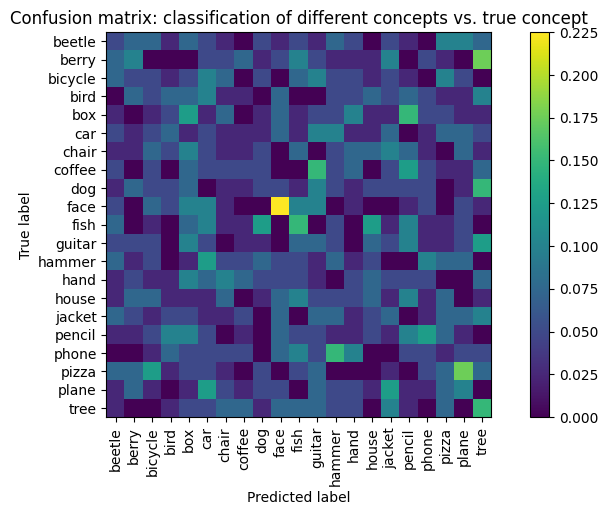

In [117]:
# plot overall confusion matrix
fig, ax = plt.subplots(figsize=(10, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=concepts)
disp.plot(ax=ax, include_values=False)

ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Confusion matrix: classification of different concepts vs. true concept")

Count how many times correct classification occured for each concept

In [ ]:
# split predictions by trials with the same concept and compute accuracy
preds = res[1]

labels = np.unique(data_y) # shape (n_trials,)
n_time, n_trials = preds.shape

# trials-by-label mask: 
mask_labtr = (data_y[:, None] == labels[None, :])

# correctness trials-by-labels mask
correct_labtr = (preds[:, :, None] == labels[None, None, :])

# correct counts per time x label: 
num_correct_labtr = (correct_labtr & mask_labtr[None, :, :]).sum(axis=1)

# trials per label: 
denom_ntrials = mask_labtr.sum(axis=0)

# --- result: per-label accuracy per timepoint in [0,1], shape (T, K) ---
per_label_acc = num_correct_labtr / denom_ntrials

Plot accuracy split by concept (oonly correct classifications for trials with this concept)

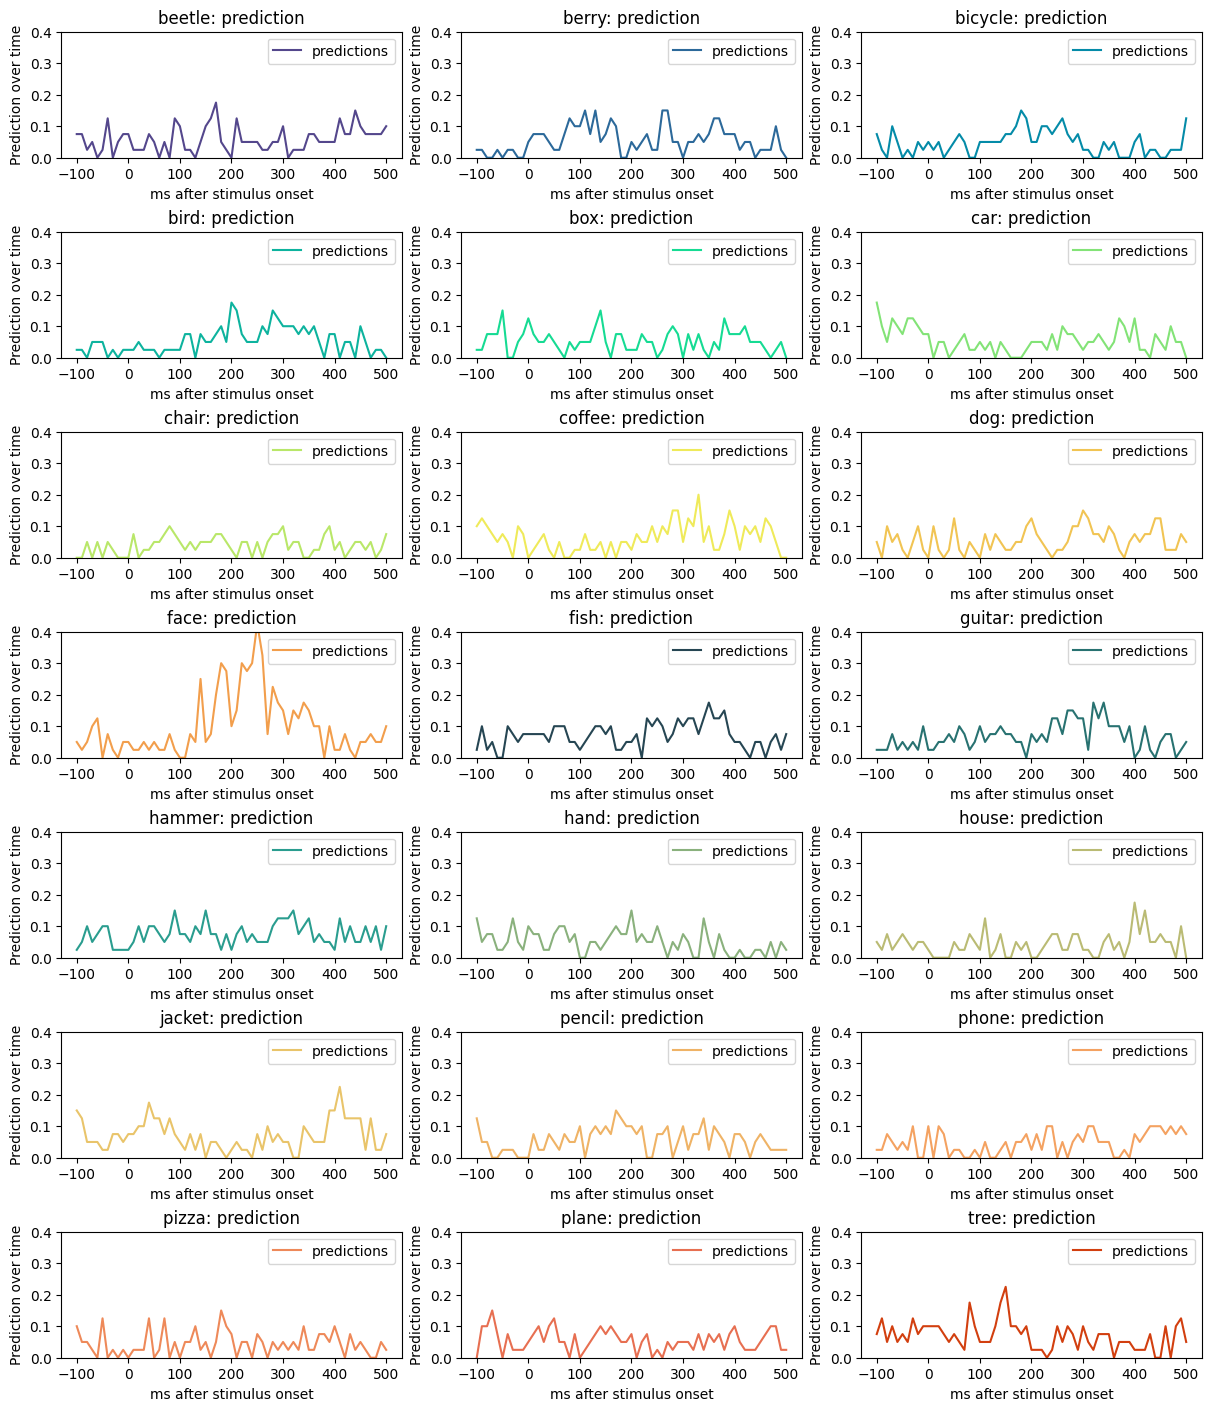

In [ ]:
   
# plot predictions over time: one subplot per classifier 
fig = plt.figure(figsize=(12, 14), constrained_layout=True)
ax = fig.subplots(7,3)
axes_flat = ax.flat  
# sns.despine()
time_vector = np.linspace(-100, 500, n_time)
for i, concept in enumerate(concepts):
    curr_ax = axes_flat[i]
    prediction = per_label_acc[:,i]

    curr_ax.plot(time_vector, prediction, color=colors_list[i])

    curr_ax.set(
        xlabel="ms after stimulus onset",
        ylabel="Prediction over time",
        title=f"{concept}: prediction",
    )
    curr_ax.set_ylim(0, 0.4)


plt.show()
fig.savefig(f"decoding_predictions_pilot1_seperate.png", bbox_inches="tight")

Plot probabilities for the right class on trials with this class vs. mean prob of other classes

In [ ]:
labels = np.unique(data_y)

# get dict to match labels to indices
label_to_idx = {lab: i for i, lab in enumerate(labels)}

# look up where labels and their index show up in data_y (true labels)
true_idx = np.vectorize(label_to_idx.get)(data_y)  # (n_trials,)

# probas should be shape n_trials x n_timepoints x n_classes
n_trials, n_time, n_classes = preds_proba.shape

# probability of the true class for each trial × time combination 
p_true = preds_proba[np.arange(n_trials)[:, None], np.arange(n_time)[None, :], true_idx[:, None]]

# average probability of all other classes (3rd dimension of proba)

# take mean here! 
p_other = (preds_proba.sum(axis=2)[:, :] - p_true) / (n_classes - 1)

# average within each class
per_class_contrast = []
for lab in labels:
    mask = data_y == lab
    # contrast = p_true - p_other, averaged over trials
    contrast = (p_true[mask] - p_other[mask]).mean(axis=0)  # (n_time,)
    per_class_contrast.append(contrast)

per_class_contrast = np.vstack(per_class_contrast)  # (n_classes, n_time)

C:\Users\sianna.groesser\AppData\Local\Temp\ipykernel_44700\2377204339.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(time_vector)


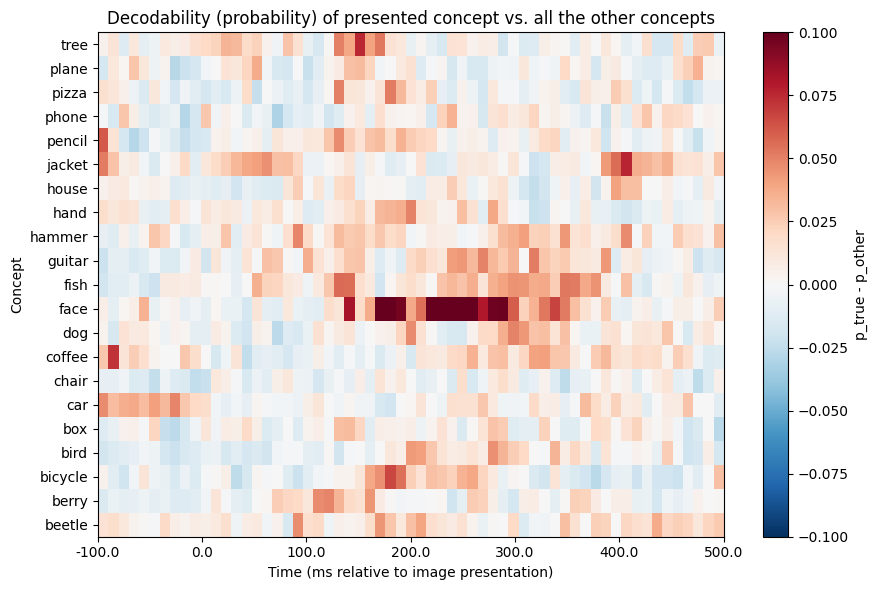

In [46]:
# plot seperability of one class from the other classes over time
time_vector = np.linspace(-100, 500, 7)

fig, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow(per_class_contrast, aspect='auto', origin='lower',
               cmap='RdBu_r', vmin=-0.1, vmax=0.1,
               extent=[time_vector[0], time_vector[-1], 0, len(labels)])  

ax.set_yticks(np.arange(len(concepts)) + 0.5)
ax.set_yticklabels(concepts)

ax.set_xticklabels(time_vector)
ax.set_xlabel("Time (ms relative to image presentation)")
ax.set_ylabel("Concept")
ax.set_title('Decodability (probability) of presented concept vs. all the other concepts')
cbar = plt.colorbar(im, ax=ax, label="p_true - p_other")
plt.tight_layout()
plt.show()

fig.savefig("localiser_prob_seperability_pilot1.png")

Cool heatmap

In [8]:
# limit time win around stim onset in data_x so it doesn't run forever
data_x_new = data_x[:, :, 15:45] # from 50 to 350 ms after stim 
len_times = 30
ms_start = 50
ms_end = 350

In [9]:
## plot heatmap for decoding accuracy for each train and test timepoint combination

# calculate time by time decoding heatmap from localizer
# basically: How well can a clf trained on t1 predict t2 of the localizer
maps_localizer = utils.get_decoding_heatmap(clf, data_x_new, data_y, ex_per_fold=ex_per_fold)

# save
with open("heatmap_results_longertime_pilot1.pkl", "wb") as f:
    pickle.dump(maps_localizer, f)

heatmap_matrix = maps_localizer[1]
results = maps_localizer[0]

# zscore maps for statistics
maps_loc_norm = np.array(heatmap_matrix) - np.mean(heatmap_matrix)
maps_loc_norm = maps_loc_norm / maps_loc_norm.std()

# perform cluster permutation testing
t_thresh = scipy.stats.distributions.t.ppf(1 - 0.05, df=len(heatmap_matrix) - 1)
t_clust, clusters1, p_values1, H0 = mne.stats.permutation_cluster_1samp_test(
    maps_loc_norm,
    tail=1,
    n_jobs=None,
    threshold=t_thresh,
    adjacency=None,
    n_permutations=1000,
    out_type="mask",
)

# select significant clusters
sig_clusters = [cl for cl, p in zip(clusters1, p_values1) if p < 0.05]

# make a boolean mask with the same shape as the image
mask = np.zeros_like(heatmap_matrix, dtype=bool)
for cl in sig_clusters: 
    if isinstance(cl, tuple):
        mask[cl] = True
    

# create mask from cluster for all clusters of p<0.05
clusters_sum1 = (np.array(clusters1)[p_values1 < 0.05]).sum(0)



 40%|████      | 7200/18000 [19:34<3:54:51,  1.30s/it]


KeyboardInterrupt: 

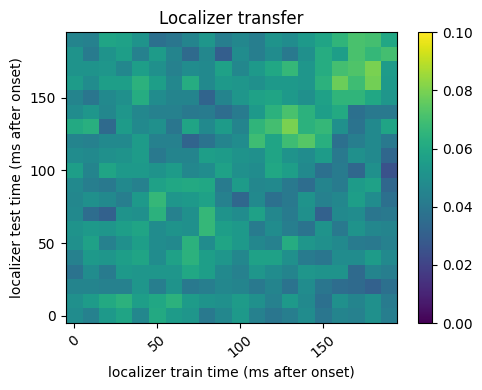

In [90]:
# now plot the heatmaps with masking using MNE visualization functions
fig = plt.figure(figsize=[5, 4])
axs = fig.subplots()
x = mne.viz.utils._plot_masked_image(
    axs,
    heatmap_matrix,
    times=range(len_times),
    mask=mask,
    cmap="viridis",
    mask_style="contour",
    vmin=0.0,
    vmax=0.1,
)
plt.colorbar(x[0])


title = "Localizer transfer"
axs.set_title(title)
times = np.arange(ms_start, ms_end, 50)  # t
axs.set_xticks(np.arange(0, len_times, 5), times, rotation=40)
axs.set_yticks(np.arange(0, len_times, 5), times)
axs.set_xlabel("localizer train time (ms after onset)")
axs.set_ylabel("localizer test time (ms after onset)")

fig.tight_layout()
fig.savefig("localiser_classifier_transfer_pilot1.png")